# Simulating asynchronous or Gamma oscillations using AdEx neurons in ``brainpy.state``

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chaobrain/brain-modeling-ecosystem/blob/main/docs/brainpy_spiking_gamma_oscillations.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/chaobrain/brain-modeling-ecosystem/blob/main/docs/brainpy_spiking_gamma_oscillations.ipynb)

Implementation of the paper:

- Susin, Eduarda, and Alain Destexhe. “Integration, coincidence detection and resonance in networks of spiking neurons expressing gamma oscillations and asynchronous states.” PLoS computational biology 17.9 (2021): e1009416. [https://pmc.ncbi.nlm.nih.gov/articles/PMC8478196/](https://pmc.ncbi.nlm.nih.gov/articles/PMC8478196/)

In [19]:
import braintools
import brainstate
import brainpy.state
import brainunit as u
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import kaiserord, lfilter, firwin, hilbert

## Parameters

In [20]:
# Table 1: specific neuron model parameters
RS_par = dict(
    Vth=-40 * u.mV, delta=2. * u.mV, tau_ref=5. * u.ms, tau_w=500 * u.ms,
    a=4 * u.nS, b=20 * u.pA, C=150 * u.pF, gL=10 * u.nS, EL=-65 * u.mV, V_reset=-65 * u.mV,
    E_e=0. * u.mV, E_i=-80. * u.mV
)
FS_par = dict(
    Vth=-47.5 * u.mV, delta=0.5 * u.mV, tau_ref=5. * u.ms, tau_w=500 * u.ms,
    a=0 * u.nS, b=0 * u.pA, C=150 * u.pF, gL=10 * u.nS, EL=-65 * u.mV, V_reset=-65 * u.mV,
    E_e=0. * u.mV, E_i=-80. * u.mV
)
Ch_par = dict(
    Vth=-47.5 * u.mV, delta=0.5 * u.mV, tau_ref=1. * u.ms, tau_w=50 * u.ms,
    a=80 * u.nS, b=150 * u.pA, C=150 * u.pF, gL=10 * u.nS, EL=-58 * u.mV, V_reset=-65 * u.mV,
    E_e=0. * u.mV, E_i=-80. * u.mV,
)

## Neuron model

In [21]:
class AdEx(brainpy.state.Neuron):
    def __init__(
        self,
        in_size,
        # neuronal parameters
        Vth=-40 * u.mV, delta=2. * u.mV, tau_ref=5. * u.ms, tau_w=500 * u.ms,
        a=4 * u.nS, b=20 * u.pA, C=150 * u.pF,
        gL=10 * u.nS, EL=-65 * u.mV, V_reset=-65 * u.mV, V_sp_th=-40. * u.mV,
        # synaptic parameters
        tau_e=1.5 * u.ms, tau_i=7.5 * u.ms, E_e=0. * u.mV, E_i=-80. * u.mV,
        # other parameters
        V_initializer=braintools.init.Uniform(-65., -50., unit=u.mV),
        w_initializer=braintools.init.Constant(0. * u.pA),
        ge_initializer=braintools.init.Constant(0. * u.nS),
        gi_initializer=braintools.init.Constant(0. * u.nS),
    ):
        super().__init__(in_size=in_size)

        # neuronal parameters
        self.Vth = Vth
        self.delta = delta
        self.tau_ref = tau_ref
        self.tau_w = tau_w
        self.a = a
        self.b = b
        self.C = C
        self.gL = gL
        self.EL = EL
        self.V_reset = V_reset
        self.V_sp_th = V_sp_th

        # synaptic parameters
        self.tau_e = tau_e
        self.tau_i = tau_i
        self.E_e = E_e
        self.E_i = E_i

        # other parameters
        self.V_initializer = V_initializer
        self.w_initializer = w_initializer
        self.ge_initializer = ge_initializer
        self.gi_initializer = gi_initializer

    def init_state(self):
        # neuronal variables
        self.V = brainstate.HiddenState(braintools.init.param(self.V_initializer, self.varshape))
        self.w = brainstate.HiddenState(braintools.init.param(self.w_initializer, self.varshape))
        self.t_last_spike = brainstate.HiddenState(braintools.init.param(braintools.init.Constant(-1e7 * u.ms), self.varshape))
        self.spike = brainstate.HiddenState(braintools.init.param(lambda s: u.math.zeros(s, bool), self.varshape))

        # synaptic parameters
        self.ge = brainstate.HiddenState(braintools.init.param(self.ge_initializer, self.varshape))
        self.gi = brainstate.HiddenState(braintools.init.param(self.gi_initializer, self.varshape))

    def dV(self, V, w, ge, gi, Iext):
        I = ge * (self.E_e - V) + gi * (self.E_i - V)
        Iext = self.sum_current_inputs(Iext)
        dVdt = (self.gL * self.delta * u.math.exp((V - self.Vth) / self.delta)
                - w + self.gL * (self.EL - V) + I + Iext) / self.C
        return dVdt

    def dw(self, w, V):
        dwdt = (self.a * (V - self.EL) - w) / self.tau_w
        return dwdt

    def update(self, x=0. * u.pA):
        # numerical integration
        ge = brainstate.nn.exp_euler_step(lambda g: -g / self.tau_e, self.ge.value)
        ge = self.sum_delta_inputs(ge, label='ge')
        gi = brainstate.nn.exp_euler_step(lambda g: -g / self.tau_i, self.gi.value)
        gi = self.sum_delta_inputs(gi, label='gi')
        V = brainstate.nn.exp_euler_step(self.dV, self.V.value, self.w.value, self.ge.value, self.gi.value, x)
        V = self.sum_delta_inputs(V, label='V')
        w = brainstate.nn.exp_euler_step(self.dw, self.w.value, self.V.value)
        # spike detection
        t = brainstate.environ.get('t')
        refractory = (t - self.t_last_spike.value) <= self.tau_ref
        V = u.math.where(refractory, self.V.value, V)
        spike = V >= self.V_sp_th
        self.V.value = u.math.where(spike, self.V_reset, V)
        self.w.value = u.math.where(spike, w + self.b, w)
        self.ge.value = ge
        self.gi.value = gi
        self.spike.value = spike
        self.t_last_spike.value = u.math.where(spike, t, self.t_last_spike.value)
        return spike


## Utility functions

In [22]:
def get_inputs(c_low, c_high, t_transition, t_min_plato, t_max_plato, t_gap, t_total):
    t = 0
    dt = brainstate.environ.get_dt()
    num_gap = int(t_gap / dt)
    num_total = int(t_total / dt)
    num_transition = int(t_transition / dt)

    inputs = []
    ramp_up = u.math.linspace(c_low, c_high, num_transition)
    ramp_down = u.math.linspace(c_high, c_low, num_transition)
    plato_base = u.math.ones(num_gap) * c_low
    while t < num_total:
        num_plato = int(brainstate.random.uniform(low=t_min_plato, high=t_max_plato) / dt)
        inputs.extend([plato_base, ramp_up, np.ones(num_plato) * c_high, ramp_down])
        t += (num_gap + num_transition + num_plato + num_transition)
    return u.math.concatenate(inputs)[:num_total]


def signal_phase_by_Hilbert(signal, signal_time, low_cut, high_cut, sampling_space):
    # sampling_space: in seconds (no units)
    # signal_time: in seconds (no units)
    # low_cut: in Hz (no units)(band to filter)
    # high_cut: in Hz (no units)(band to filter)

    signal = signal - np.mean(signal)
    width = 5.0  # The desired width in Hz of the transition from pass to stop
    ripple_db = 60.0  # The desired attenuation in the stop band, in dB.
    sampling_rate = 1. / sampling_space
    Nyquist = sampling_rate / 2.

    num_taps, beta = kaiserord(ripple_db, width / Nyquist)
    if num_taps % 2 == 0:
        num_taps = num_taps + 1  # Numtaps must be odd
    taps = firwin(num_taps, [low_cut / Nyquist, high_cut / Nyquist], window=('kaiser', beta),
                  pass_zero=False, scale=True)
    filtered_signal = lfilter(taps, 1.0, signal)
    delay = 0.5 * (num_taps - 1) / sampling_rate  # To corrected to zero-phase
    delay_index = int(np.floor(delay * sampling_rate))
    filtered_signal = filtered_signal[num_taps - 1:]  # taking out the "corrupted" signal
    # correcting the delay and taking out the "corrupted" signal part
    filtered_time = signal_time[num_taps - 1:] - delay
    cutted_signal = signal[(num_taps - 1 - delay_index): (len(signal) - (num_taps - 1 - delay_index))]

    # --------------------------------------------------------------------------
    # The hilbert transform are very slow when the signal has odd lenght,
    # This part check if the length is odd, and if this is the case it adds a zero in the end
    # of all the vectors related to the filtered Signal:
    if len(filtered_signal) % 2 != 0:  # If the lengh is odd
        tmp1 = filtered_signal.tolist()
        tmp1.append(0)
        tmp2 = filtered_time.tolist()
        tmp2.append((len(filtered_time) + 1) * sampling_space + filtered_time[0])
        tmp3 = cutted_signal.tolist()
        tmp3.append(0)
        filtered_signal = np.asarray(tmp1)
        filtered_time = np.asarray(tmp2)
        cutted_signal = np.asarray(tmp3)
    # --------------------------------------------------------------------------

    ht_filtered_signal = hilbert(filtered_signal)
    envelope = np.abs(ht_filtered_signal)
    phase = np.angle(ht_filtered_signal)  # The phase is between -pi and pi in radians

    return filtered_time, filtered_signal, cutted_signal, envelope, phase


def visualize_simulation_results(
    times, spikes, example_potentials, varied_rates,
    xlim=None, t_lfp_start=None, t_lfp_end=None, filename=None
):
    times = times.to_decimal(u.ms)
    varied_rates = varied_rates.to_decimal(u.Hz)
    example_potentials = {k: v.to_decimal(u.mV) for k, v in example_potentials.items()}

    fig, gs = braintools.visualize.get_figure(7, 1, 1, 12)
    # 1. input firing rate
    ax = fig.add_subplot(gs[0])
    plt.plot(times, varied_rates)
    if xlim is None:
        xlim = (0, times[-1])
    else:
        xlim = (xlim[0].to_decimal(u.ms), xlim[1].to_decimal(u.ms))
    ax.set_xlim(*xlim)
    ax.set_xticks([])
    ax.set_ylabel('External\nRate (Hz)')

    # 2. inhibitory cell rater plot
    ax = fig.add_subplot(gs[1: 3])
    i = 0
    y_ticks = ([], [])
    for key, (sp_matrix, sp_type) in spikes.items():
        iis, sps = np.where(sp_matrix)
        tts = times[iis]
        plt.scatter(tts, sps + i, s=1, label=key)
        y_ticks[0].append(i + sp_matrix.shape[1] / 2)
        y_ticks[1].append(key)
        i += sp_matrix.shape[1]
    ax.set_xlim(*xlim)
    ax.set_xlabel('')
    ax.set_ylabel('Neuron Index')
    ax.set_xticks([])
    ax.set_yticks(*y_ticks)

    # 3. example membrane potential
    ax = fig.add_subplot(gs[3: 5])
    for key, potential in example_potentials.items():
        vs = np.where(spikes[key][0][:, 0], 0, potential)
        plt.plot(times, vs, label=key)
    ax.set_xlim(*xlim)
    ax.set_xticks([])
    ax.set_ylabel('V (mV)')
    ax.legend()

    # 4. LFP
    ax = fig.add_subplot(gs[5:7])
    ax.set_xlim(*xlim)
    t1 = int(t_lfp_start / brainstate.environ.get_dt()) if t_lfp_start is not None else 0
    t2 = int(t_lfp_end / brainstate.environ.get_dt()) if t_lfp_end is not None else len(times)
    times = times[t1: t2]
    lfp = 0
    for sp_matrix, sp_type in spikes.values():
        lfp += braintools.metric.unitary_LFP(times, sp_matrix[t1: t2], sp_type)
    phase_ts, filtered, cutted, envelope, _ = signal_phase_by_Hilbert(
        lfp, times * 1e-3, 30, 50, brainstate.environ.get_dt() / u.second
    )
    plt.plot(phase_ts * 1e3, cutted, color='k', label='Raw LFP')
    plt.plot(phase_ts * 1e3, filtered, color='orange', label="Filtered LFP (30-50 Hz)")
    plt.plot(phase_ts * 1e3, envelope, color='purple', label="Hilbert Envelope")
    plt.legend(loc='best')
    plt.xlabel('Time (ms)')

    # save or show
    if filename:
        plt.savefig(filename, dpi=500)
    plt.show()

## Neuron dynamics simulation

In [23]:
def simulate_adex_neuron(ax_v, ax_I, pars, title):
    with brainstate.environ.context(dt=0.1 * u.ms):
        # neuron
        adex = brainstate.nn.init_all_states(AdEx(1, **pars))

        def run_step(t, x):
            with brainstate.environ.context(t=t):
                adex.update(x)
                return adex.V.value

        # simulation
        duration = 1.5e3 * u.ms
        times = u.math.arange(0. * u.ms, duration, brainstate.environ.get_dt())
        inputs = get_inputs(0. * u.nA, 0.5 * u.nA, t_transition=50. * u.ms,
                            t_min_plato=500 * u.ms, t_max_plato=500 * u.ms,
                            t_gap=500 * u.ms, t_total=duration)
        vs = brainstate.transform.for_loop(run_step, times, inputs, pbar=brainstate.transform.ProgressBar(10))

        # visualization
        ax_v.plot(times.to_decimal(u.ms), vs.to_decimal(u.mV))
        ax_v.set_title(title)
        ax_v.set_ylabel('V (mV)')
        ax_v.set_xlim(0.4 * u.second / u.ms, 1.2 * u.second / u.ms)

        ax_I.plot(times.to_decimal(u.ms), inputs.to_decimal(u.nA))
        ax_I.set_ylabel('I (nA)')
        ax_I.set_xlabel('Time (ms)')
        ax_I.set_xlim(0.4 * u.second / u.ms, 1.2 * u.second / u.ms)


def simulate_adex_neurons():
    fig, gs = braintools.visualize.get_figure(2, 3, 4, 6)
    simulate_adex_neuron(fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[1, 0]), RS_par, 'Regular Spiking')
    simulate_adex_neuron(fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[1, 1]), FS_par, 'Fast Spiking')
    simulate_adex_neuron(fig.add_subplot(gs[0, 2]), fig.add_subplot(gs[1, 2]), Ch_par, 'Chattering')
    plt.show()

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

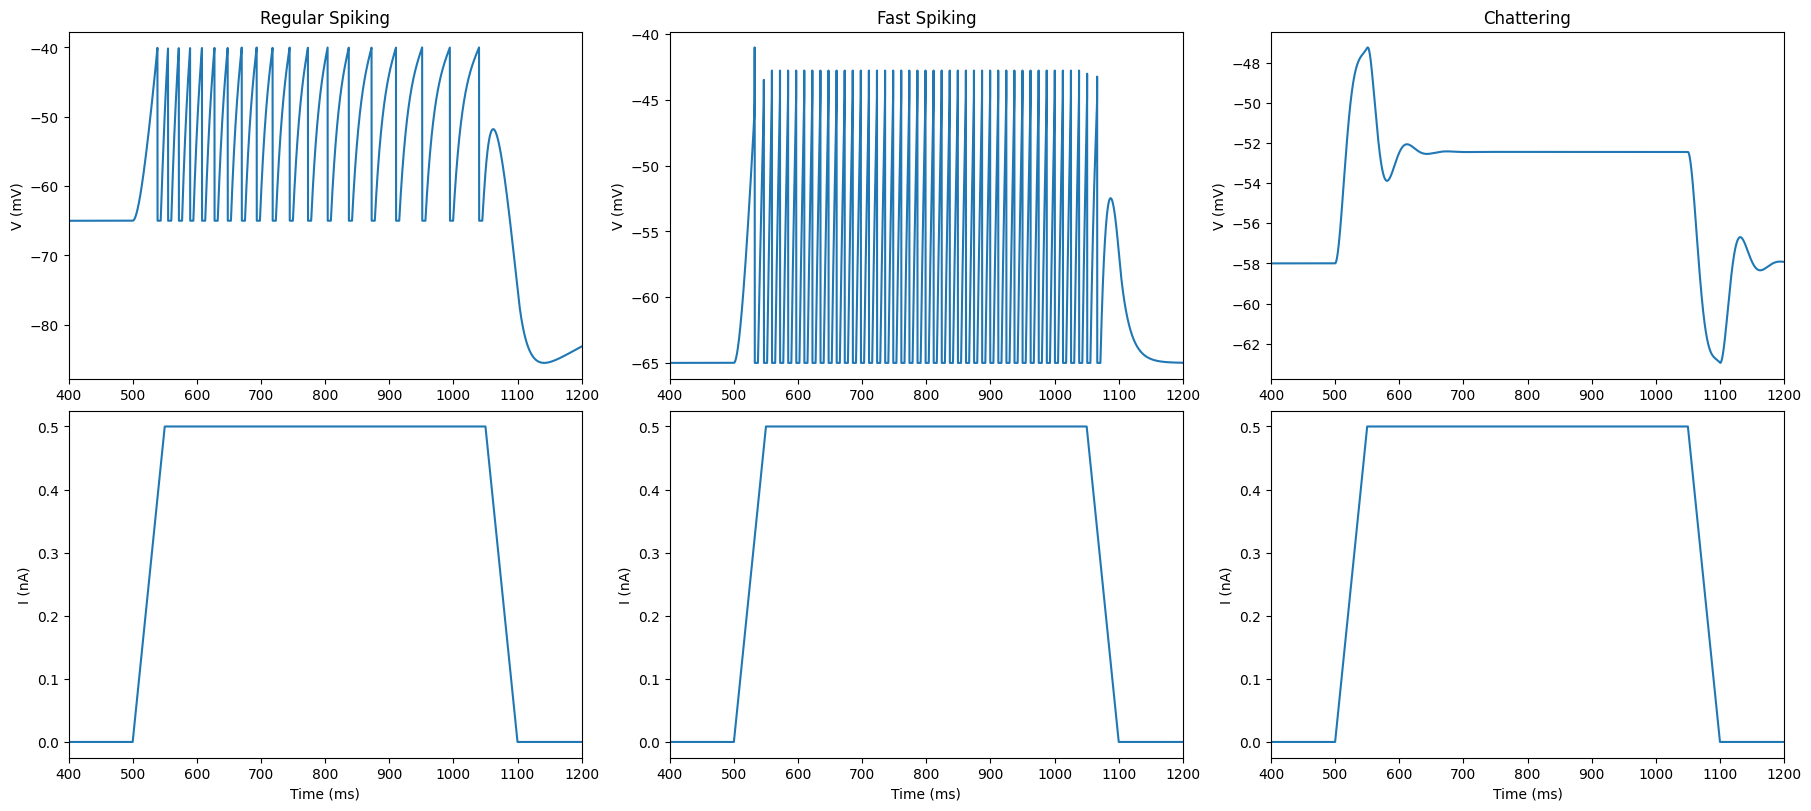

In [24]:
simulate_adex_neurons()

## PING Network for Generating Gamma Oscillation

In [25]:
class PINGNet(brainstate.nn.Module):
    def __init__(self):
        super().__init__()

        self.num_exc = 20000
        self.num_inh = 5000
        self.exc_syn_tau = 1. * u.ms
        self.inh_syn_tau = 7.5 * u.ms
        self.exc_syn_weight = 5. * u.nS
        self.inh_syn_weight = 3.34 * u.nS
        self.ext_weight = 4. * u.nS
        self.delay = 1.5 * u.ms

        # neuronal populations
        RS_par_ = RS_par.copy()
        FS_par_ = FS_par.copy()
        RS_par_.update(Vth=-50 * u.mV, V_sp_th=-40 * u.mV)
        FS_par_.update(Vth=-50 * u.mV, V_sp_th=-40 * u.mV)
        self.rs_pop = AdEx(self.num_exc, tau_e=self.exc_syn_tau, tau_i=self.inh_syn_tau, **RS_par_)
        self.fs_pop = AdEx(self.num_inh, tau_e=self.exc_syn_tau, tau_i=self.inh_syn_tau, **FS_par_)
        self.ext_pop = brainpy.state.PoissonEncoder(self.num_exc)

        # Poisson inputs
        self.ext_to_FS = brainpy.state.DeltaProj(
            comm=brainstate.nn.EventFixedProb(self.num_exc, self.num_inh, 0.02, self.ext_weight),
            post=self.fs_pop,
            label='ge'
        )
        self.ext_to_RS = brainpy.state.DeltaProj(
            comm=brainstate.nn.EventFixedProb(self.num_exc, self.num_exc, 0.02, self.ext_weight),
            post=self.rs_pop,
            label='ge'
        )

        # synaptic projections
        self.RS_to_FS = brainpy.state.DeltaProj(
            self.rs_pop.prefetch('spike').delay.at(self.delay),
            comm=brainstate.nn.EventFixedProb(self.num_exc, self.num_inh, 0.02, self.exc_syn_weight),
            post=self.fs_pop,
            label='ge'
        )
        self.RS_to_RS = brainpy.state.DeltaProj(
            self.rs_pop.prefetch('spike').delay.at(self.delay),
            comm=brainstate.nn.EventFixedProb(self.num_exc, self.num_exc, 0.02, self.exc_syn_weight),
            post=self.rs_pop,
            label='ge'
        )
        self.FS_to_RS = brainpy.state.DeltaProj(
            self.fs_pop.prefetch('spike').delay.at(self.delay),
            comm=brainstate.nn.EventFixedProb(self.num_inh, self.num_exc, 0.02, self.inh_syn_weight),
            post=self.rs_pop,
            label='gi'
        )
        self.FS_to_FS = brainpy.state.DeltaProj(
            self.fs_pop.prefetch('spike').delay.at(self.delay),
            comm=brainstate.nn.EventFixedProb(self.num_inh, self.num_inh, 0.02, self.inh_syn_weight),
            post=self.fs_pop,
            label='gi'
        )

    def update(self, i, t, freq):
        with brainstate.environ.context(t=t, i=i):
            ext_spikes = self.ext_pop(freq)
            self.ext_to_FS(ext_spikes)
            self.ext_to_RS(ext_spikes)

            self.RS_to_RS()
            self.RS_to_FS()

            self.FS_to_RS()
            self.FS_to_FS()

            self.rs_pop()
            self.fs_pop()

            return {
                'FS.V0': self.fs_pop.V.value[0],
                'RS.V0': self.rs_pop.V.value[0],
                'FS.spike': self.fs_pop.spike.value,
                'RS.spike': self.rs_pop.spike.value
            }

In [26]:
def simulate_ping_net():
    with brainstate.environ.context(dt=0.1 * u.ms):
        # inputs
        duration = 6e3 * u.ms
        varied_rates = get_inputs(2. * u.Hz, 3. * u.Hz, 50. * u.ms, 3150 * u.ms, 600 * u.ms, 1e3 * u.ms, duration)

        # network
        net = brainstate.nn.init_all_states(PINGNet())

        # simulation
        times = u.math.arange(0. * u.ms, duration, brainstate.environ.get_dt())
        indices = u.math.arange(0, len(times))
        returns = brainstate.transform.for_loop(net.update, indices, times, varied_rates,
                                              pbar=brainstate.transform.ProgressBar(100))

        # visualization
        visualize_simulation_results(
            times=times,
            spikes={'FS': (returns['FS.spike'], 'inh'),
                    'RS': (returns['RS.spike'], 'exc')},
            example_potentials={'FS': returns['FS.V0'],
                                'RS': returns['RS.V0']},
            varied_rates=varied_rates,
            xlim=(2e3 * u.ms, 3.4e3 * u.ms),
            t_lfp_start=1e3 * u.ms,
            t_lfp_end=5e3 * u.ms
        )

  0%|          | 0/60000 [00:00<?, ?it/s]

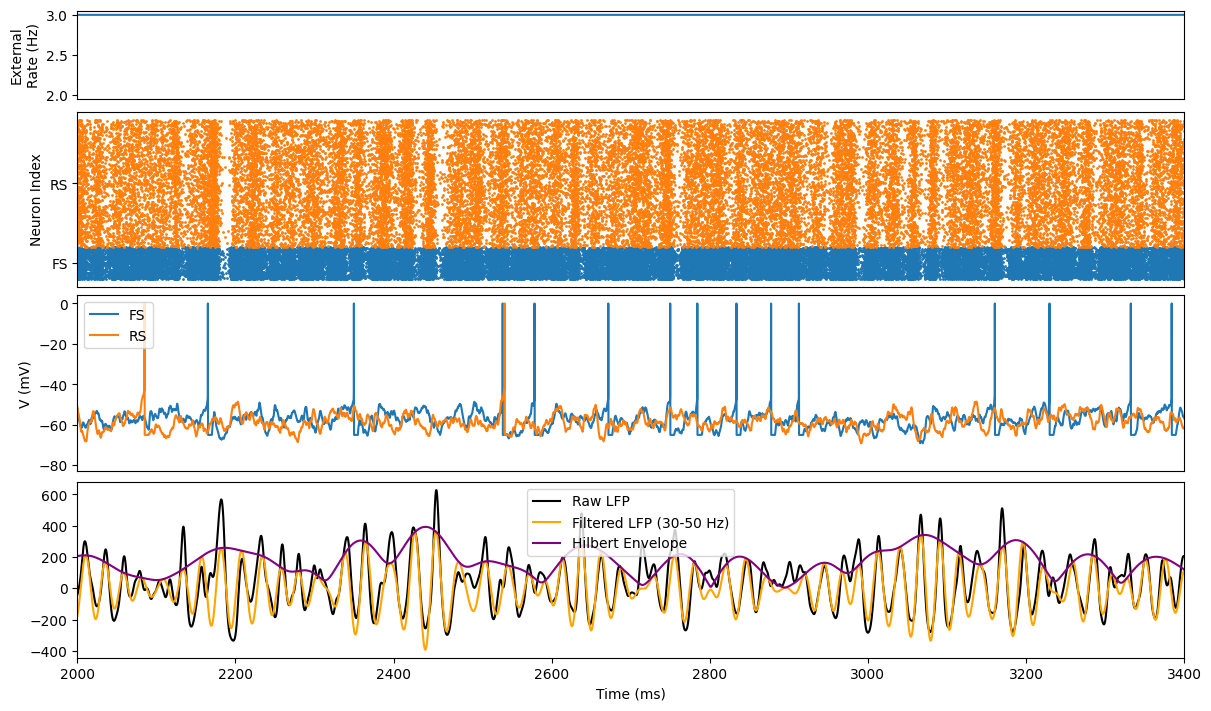

In [27]:
simulate_ping_net()

## ING Network for Generating Gamma Oscillation

In [28]:
class INGNet(brainstate.nn.Module):
    def __init__(self):
        super().__init__()

        self.num_rs = 20000
        self.num_fs = 4000
        self.num_fs2 = 1000
        self.exc_syn_tau = 5. * u.ms
        self.inh_syn_tau = 5. * u.ms
        self.ext_weight = 0.9 * u.nS
        self.exc_syn_weight = 1. * u.nS
        self.inh_syn_weight = 5. * u.nS
        self.delay = 1.5 * u.ms

        # neuronal populations
        RS_par_ = RS_par.copy()
        FS_par_ = FS_par.copy()
        FS2_par_ = FS_par.copy()
        RS_par_.update(Vth=-50 * u.mV, V_sp_th=-40 * u.mV)
        FS_par_.update(Vth=-50 * u.mV, V_sp_th=-40 * u.mV)
        FS2_par_.update(Vth=-50 * u.mV, V_sp_th=-40 * u.mV)
        self.rs_pop = AdEx(self.num_rs, tau_e=self.exc_syn_tau, tau_i=self.inh_syn_tau, **RS_par_)
        self.fs_pop = AdEx(self.num_fs, tau_e=self.exc_syn_tau, tau_i=self.inh_syn_tau, **FS_par_)
        self.fs2_pop = AdEx(self.num_fs2, tau_e=self.exc_syn_tau, tau_i=self.inh_syn_tau, **FS2_par_)
        self.ext_pop = brainpy.state.PoissonEncoder(self.num_rs)

        # Poisson inputs
        self.ext_to_FS = brainpy.state.DeltaProj(
            comm=brainstate.nn.EventFixedProb(self.num_rs, self.num_fs, 0.02, self.ext_weight),
            post=self.fs_pop,
            label='ge'
        )
        self.ext_to_RS = brainpy.state.DeltaProj(
            comm=brainstate.nn.EventFixedProb(self.num_rs, self.num_rs, 0.02, self.ext_weight),
            post=self.rs_pop,
            label='ge'
        )
        self.ext_to_RS2 = brainpy.state.DeltaProj(
            comm=brainstate.nn.EventFixedProb(self.num_rs, self.num_fs2, 0.02, self.ext_weight),
            post=self.fs2_pop,
            label='ge'
        )

        # synaptic projections
        self.RS_to_FS = brainpy.state.DeltaProj(
            self.rs_pop.prefetch('spike').delay.at(self.delay),
            comm=brainstate.nn.EventFixedProb(self.num_rs, self.num_fs, 0.02, self.exc_syn_weight),
            post=self.fs_pop,
            label='ge'
        )
        self.RS_to_RS = brainpy.state.DeltaProj(
            self.rs_pop.prefetch('spike').delay.at(self.delay),
            comm=brainstate.nn.EventFixedProb(self.num_rs, self.num_rs, 0.02, self.exc_syn_weight),
            post=self.rs_pop,
            label='ge'
        )
        self.RS_to_FS2 = brainpy.state.DeltaProj(
            self.rs_pop.prefetch('spike').delay.at(self.delay),
            comm=brainstate.nn.EventFixedProb(self.num_rs, self.num_fs2, 0.15, self.exc_syn_weight),
            post=self.fs2_pop,
            label='ge'
        )

        self.FS_to_RS = brainpy.state.DeltaProj(
            self.fs_pop.prefetch('spike').delay.at(self.delay),
            comm=brainstate.nn.EventFixedProb(self.num_fs, self.num_rs, 0.02, self.inh_syn_weight),
            post=self.rs_pop,
            label='gi'
        )
        self.FS_to_FS = brainpy.state.DeltaProj(
            self.fs_pop.prefetch('spike').delay.at(self.delay),
            comm=brainstate.nn.EventFixedProb(self.num_fs, self.num_fs, 0.02, self.inh_syn_weight),
            post=self.fs_pop,
            label='gi'
        )
        self.FS_to_FS2 = brainpy.state.DeltaProj(
            self.fs_pop.prefetch('spike').delay.at(self.delay),
            comm=brainstate.nn.EventFixedProb(self.num_fs, self.num_fs2, 0.03, self.inh_syn_weight),
            post=self.fs2_pop,
            label='gi'
        )

        self.FS2_to_RS = brainpy.state.DeltaProj(
            self.fs2_pop.prefetch('spike').delay.at(self.delay),
            comm=brainstate.nn.EventFixedProb(self.num_fs2, self.num_rs, 0.15, self.exc_syn_weight),
            post=self.rs_pop,
            label='gi'
        )
        self.FS2_to_FS = brainpy.state.DeltaProj(
            self.fs2_pop.prefetch('spike').delay.at(self.delay),
            comm=brainstate.nn.EventFixedProb(self.num_fs2, self.num_fs, 0.15, self.exc_syn_weight),
            post=self.fs_pop,
            label='gi'
        )
        self.FS2_to_FS2 = brainpy.state.DeltaProj(
            self.fs2_pop.prefetch('spike').delay.at(self.delay),
            comm=brainstate.nn.EventFixedProb(self.num_fs2, self.num_fs2, 0.6, self.exc_syn_weight),
            post=self.fs2_pop,
            label='gi'
        )

    def update(self, i, t, freq):
        with brainstate.environ.context(t=t, i=i):
            ext_spikes = self.ext_pop(freq)
            self.ext_to_FS(ext_spikes)
            self.ext_to_RS(ext_spikes)
            self.ext_to_RS2(ext_spikes)

            self.RS_to_RS()
            self.RS_to_FS()
            self.RS_to_FS2()

            self.FS_to_RS()
            self.FS_to_FS()
            self.FS_to_FS2()

            self.FS2_to_RS()
            self.FS2_to_FS()
            self.FS2_to_FS2()

            self.rs_pop()
            self.fs_pop()
            self.fs2_pop()

            return {
                'FS.V0': self.fs_pop.V.value[0],
                'FS2.V0': self.fs2_pop.V.value[0],
                'RS.V0': self.rs_pop.V.value[0],
                'FS.spike': self.fs_pop.spike.value,
                'FS2.spike': self.fs2_pop.spike.value,
                'RS.spike': self.rs_pop.spike.value
            }

In [29]:
def simulate_ing_net():
    with brainstate.environ.context(dt=0.1 * u.ms):
        # inputs
        duration = 6e3 * u.ms
        varied_rates = get_inputs(2. * u.Hz, 3. * u.Hz, 50. * u.ms, 350 * u.ms, 600 * u.ms, 1e3 * u.ms, duration)

        # network
        net = brainstate.nn.init_all_states(INGNet())

        # simulation
        times = u.math.arange(0. * u.ms, duration, brainstate.environ.get_dt())
        indices = u.math.arange(0, len(times))
        returns = brainstate.transform.for_loop(net.update, indices, times, varied_rates,
                                              pbar=brainstate.transform.ProgressBar(100))

        # visualization
        visualize_simulation_results(
            times=times,
            spikes={'FS': (returns['FS.spike'], 'inh'),
                    'FS2': (returns['FS2.spike'], 'inh'),
                    'RS': (returns['RS.spike'], 'exc')},
            example_potentials={'FS': returns['FS.V0'],
                                'FS2': returns['FS2.V0'],
                                'RS': returns['RS.V0']},
            varied_rates=varied_rates,
            xlim=(2e3 * u.ms, 3.4e3 * u.ms),
            t_lfp_start=1e3 * u.ms,
            t_lfp_end=5e3 * u.ms
        )

  0%|          | 0/60000 [00:00<?, ?it/s]

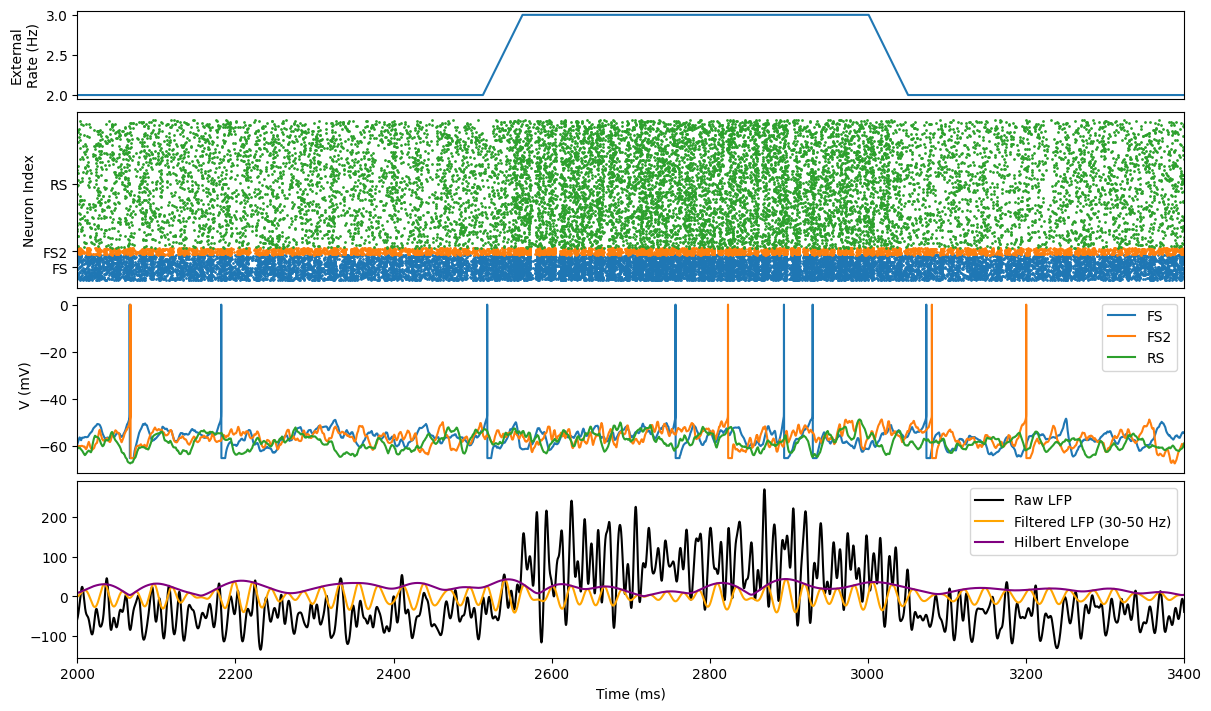

In [30]:
simulate_ing_net()

## CHING Network for Generating Gamma Oscillation

In [31]:
class CHINGNet(brainstate.nn.Module):
    def __init__(self):
        super().__init__()

        self.num_rs = 19000
        self.num_fs = 5000
        self.num_ch = 1000
        self.exc_syn_tau = 5. * u.ms
        self.inh_syn_tau = 5. * u.ms
        self.exc_syn_weight = 1. * u.nS
        self.inh_syn_weight1 = 7. * u.nS
        self.inh_syn_weight2 = 5. * u.nS
        self.ext_weight1 = 1. * u.nS
        self.ext_weight2 = 0.75 * u.nS
        self.delay = 1.5 * u.ms

        # neuronal populations
        RS_par_ = RS_par.copy()
        FS_par_ = FS_par.copy()
        Ch_par_ = Ch_par.copy()
        RS_par_.update(Vth=-50 * u.mV, V_sp_th=-40 * u.mV)
        FS_par_.update(Vth=-50 * u.mV, V_sp_th=-40 * u.mV)
        Ch_par_.update(Vth=-50 * u.mV, V_sp_th=-40 * u.mV)
        self.rs_pop = AdEx(self.num_rs, tau_e=self.exc_syn_tau, tau_i=self.inh_syn_tau, **RS_par_)
        self.fs_pop = AdEx(self.num_fs, tau_e=self.exc_syn_tau, tau_i=self.inh_syn_tau, **FS_par_)
        self.ch_pop = AdEx(self.num_ch, tau_e=self.exc_syn_tau, tau_i=self.inh_syn_tau, **Ch_par_)
        self.ext_pop = brainpy.state.PoissonEncoder(self.num_rs)

        # Poisson inputs
        self.ext_to_FS = brainpy.state.DeltaProj(
            comm=brainstate.nn.EventFixedProb(self.num_rs, self.num_fs, 0.02, self.ext_weight2),
            post=self.fs_pop,
            label='ge',
        )
        self.ext_to_RS = brainpy.state.DeltaProj(
            comm=brainstate.nn.EventFixedProb(self.num_rs, self.num_rs, 0.02, self.ext_weight1),
            post=self.rs_pop,
            label='ge',
        )
        self.ext_to_CH = brainpy.state.DeltaProj(
            comm=brainstate.nn.EventFixedProb(self.num_rs, self.num_ch, 0.02, self.ext_weight1),
            post=self.ch_pop,
            label='ge',
        )

        # synaptic projections
        self.RS_to_FS = brainpy.state.DeltaProj(
            self.rs_pop.prefetch('spike').delay.at(self.delay),
            comm=brainstate.nn.EventFixedProb(self.num_rs, self.num_fs, 0.02, self.exc_syn_weight),
            post=self.fs_pop,
            label='ge',
        )
        self.RS_to_RS = brainpy.state.DeltaProj(
            self.rs_pop.prefetch('spike').delay.at(self.delay),
            comm=brainstate.nn.EventFixedProb(self.num_rs, self.num_rs, 0.02, self.exc_syn_weight),
            post=self.rs_pop,
            label='ge',
        )
        self.RS_to_Ch = brainpy.state.DeltaProj(
            self.rs_pop.prefetch('spike').delay.at(self.delay),
            comm=brainstate.nn.EventFixedProb(self.num_rs, self.num_ch, 0.02, self.exc_syn_weight),
            post=self.ch_pop,
            label='ge',
        )

        # inhibitory projections
        self.FS_to_RS = brainpy.state.DeltaProj(
            self.fs_pop.prefetch('spike').delay.at(self.delay),
            comm=brainstate.nn.EventFixedProb(self.num_fs, self.num_rs, 0.02, self.inh_syn_weight1),
            post=self.rs_pop,
            label='gi',
        )
        self.FS_to_FS = brainpy.state.DeltaProj(
            self.fs_pop.prefetch('spike').delay.at(self.delay),
            comm=brainstate.nn.EventFixedProb(self.num_fs, self.num_fs, 0.02, self.inh_syn_weight2),
            post=self.fs_pop,
            label='gi',
        )
        self.FS_to_Ch = brainpy.state.DeltaProj(
            self.fs_pop.prefetch('spike').delay.at(self.delay),
            comm=brainstate.nn.EventFixedProb(self.num_fs, self.num_ch, 0.02, self.inh_syn_weight1),
            post=self.ch_pop,
            label='gi',
        )

        # chatter cell projections
        self.Ch_to_RS = brainpy.state.DeltaProj(
            self.ch_pop.prefetch('spike').delay.at(self.delay),
            comm=brainstate.nn.EventFixedProb(self.num_ch, self.num_rs, 0.02, self.exc_syn_weight),
            post=self.rs_pop,
            label='ge',
        )
        self.Ch_to_FS = brainpy.state.DeltaProj(
            self.ch_pop.prefetch('spike').delay.at(self.delay),
            comm=brainstate.nn.EventFixedProb(self.num_ch, self.num_fs, 0.02, self.exc_syn_weight),
            post=self.fs_pop,
            label='ge',
        )
        self.Ch_to_Ch = brainpy.state.DeltaProj(
            self.ch_pop.prefetch('spike').delay.at(self.delay),
            comm=brainstate.nn.EventFixedProb(self.num_ch, self.num_ch, 0.02, self.exc_syn_weight),
            post=self.ch_pop,
            label='ge',
        )

    def update(self, i, t, freq):
        with brainstate.environ.context(i=i, t=t):
            ext_spikes = self.ext_pop(freq)
            self.ext_to_FS(ext_spikes)
            self.ext_to_RS(ext_spikes)
            self.ext_to_CH(ext_spikes)

            self.RS_to_FS()
            self.RS_to_RS()
            self.RS_to_Ch()

            self.FS_to_RS()
            self.FS_to_FS()
            self.FS_to_Ch()

            self.Ch_to_RS()
            self.Ch_to_FS()
            self.Ch_to_Ch()

            self.rs_pop()
            self.fs_pop()
            self.ch_pop()

            return {
                'FS.V0': self.fs_pop.V.value[0],
                'CH.V0': self.ch_pop.V.value[0],
                'RS.V0': self.rs_pop.V.value[0],
                'FS.spike': self.fs_pop.spike.value,
                'CH.spike': self.ch_pop.spike.value,
                'RS.spike': self.rs_pop.spike.value
            }

In [32]:
def simulate_ching_net():
    with brainstate.environ.context(dt=0.1 * u.ms):
        # inputs
        duration = 6e3 * u.ms
        varied_rates = get_inputs(1. * u.Hz, 2. * u.Hz, 50. * u.ms, 150 * u.ms, 600 * u.ms, 1e3 * u.ms, duration)

        # network
        net = brainstate.nn.init_all_states(CHINGNet())

        # simulation
        times = u.math.arange(0. * u.ms, duration, brainstate.environ.get_dt())
        indices = u.math.arange(0, len(times))
        returns = brainstate.transform.for_loop(net.update, indices, times, varied_rates,
                                              pbar=brainstate.transform.ProgressBar(100))

        # visualization
        visualize_simulation_results(
            times=times,
            spikes={'FS': (returns['FS.spike'], 'inh'),
                    'CH': (returns['CH.spike'], 'exc'),
                    'RS': (returns['RS.spike'], 'exc')},
            example_potentials={'FS': returns['FS.V0'],
                                'CH': returns['CH.V0'],
                                'RS': returns['RS.V0']},
            varied_rates=varied_rates,
            xlim=(2e3 * u.ms, 3.4e3 * u.ms),
            t_lfp_start=1e3 * u.ms,
            t_lfp_end=5e3 * u.ms
        )

  0%|          | 0/60000 [00:00<?, ?it/s]

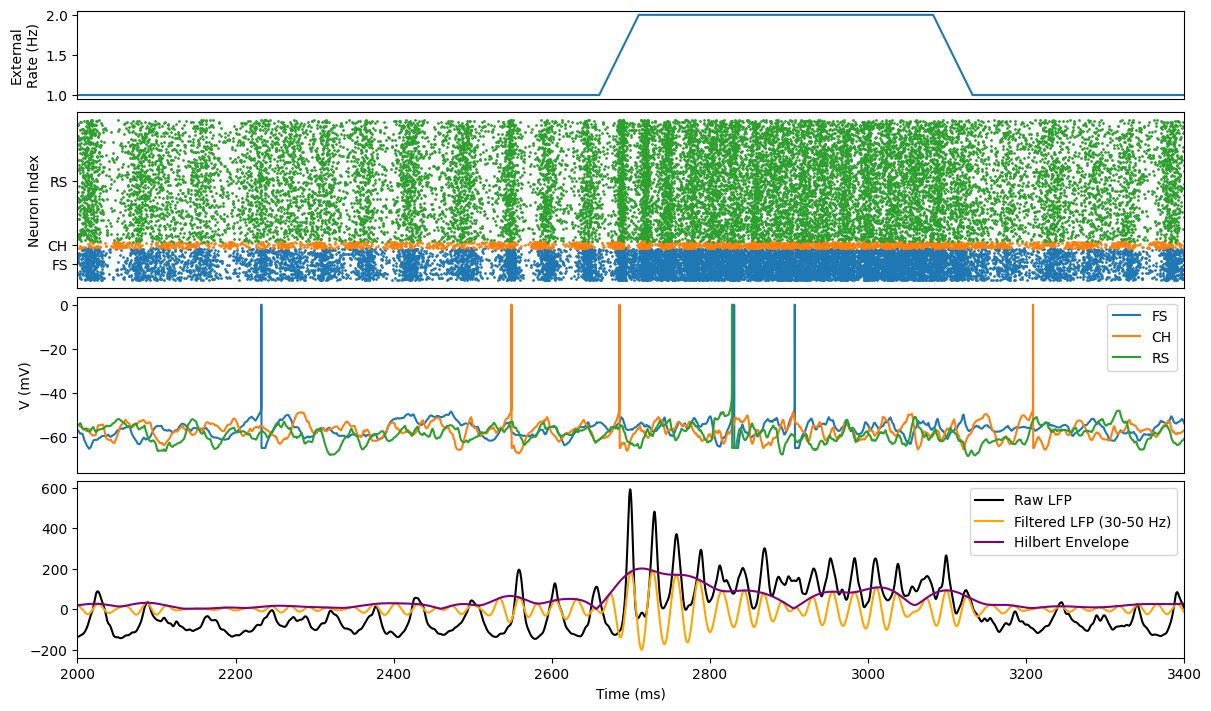

In [33]:
simulate_ching_net()

## Asynchronous Network State

In [34]:
class AINet(brainstate.nn.Module):
    def __init__(self):
        super().__init__()

        self.num_exc = 20000
        self.num_inh = 5000
        self.exc_syn_tau = 5. * u.ms
        self.inh_syn_tau = 5. * u.ms
        self.exc_syn_weight = 1. * u.nS
        self.inh_syn_weight = 5. * u.nS
        self.delay = 1.5 * u.ms
        self.ext_weight = 1.0 * u.nS

        # neuronal populations
        RS_par_ = RS_par.copy()
        FS_par_ = FS_par.copy()
        RS_par_.update(Vth=-50 * u.mV, V_sp_th=-40 * u.mV)
        FS_par_.update(Vth=-50 * u.mV, V_sp_th=-40 * u.mV)
        self.fs_pop = AdEx(self.num_inh, tau_e=self.exc_syn_tau, tau_i=self.inh_syn_tau, **FS_par_)
        self.rs_pop = AdEx(self.num_exc, tau_e=self.exc_syn_tau, tau_i=self.inh_syn_tau, **RS_par_)
        self.ext_pop = brainpy.state.PoissonEncoder(self.num_exc)

        # Poisson inputs
        self.ext_to_FS = brainpy.state.DeltaProj(
            comm=brainstate.nn.EventFixedProb(self.num_exc, self.num_inh, 0.02, self.ext_weight),
            post=self.fs_pop,
            label='ge'
        )
        self.ext_to_RS = brainpy.state.DeltaProj(
            comm=brainstate.nn.EventFixedProb(self.num_exc, self.num_exc, 0.02, self.ext_weight),
            post=self.rs_pop,
            label='ge'
        )

        # synaptic projections
        self.RS_to_FS = brainpy.state.DeltaProj(
            self.rs_pop.prefetch('spike').delay.at(self.delay),
            comm=brainstate.nn.EventFixedProb(self.num_exc, self.num_inh, 0.02, self.exc_syn_weight),
            post=self.fs_pop,
            label='ge'
        )
        self.RS_to_RS = brainpy.state.DeltaProj(
            self.rs_pop.prefetch('spike').delay.at(self.delay),
            comm=brainstate.nn.EventFixedProb(self.num_exc, self.num_exc, 0.02, self.exc_syn_weight),
            post=self.rs_pop,
            label='ge'
        )
        self.FS_to_FS = brainpy.state.DeltaProj(
            self.fs_pop.prefetch('spike').delay.at(self.delay),
            comm=brainstate.nn.EventFixedProb(self.num_inh, self.num_inh, 0.02, self.inh_syn_weight),
            post=self.fs_pop,
            label='gi'
        )
        self.FS_to_RS = brainpy.state.DeltaProj(
            self.fs_pop.prefetch('spike').delay.at(self.delay),
            comm=brainstate.nn.EventFixedProb(self.num_inh, self.num_exc, 0.02, self.inh_syn_weight),
            post=self.rs_pop,
            label='gi'
        )

    def update(self, i, t, freq):
        with brainstate.environ.context(t=t, i=i):
            ext_spikes = self.ext_pop(freq)
            self.ext_to_FS(ext_spikes)
            self.ext_to_RS(ext_spikes)
            self.RS_to_RS()
            self.RS_to_FS()
            self.FS_to_FS()
            self.FS_to_RS()
            self.rs_pop()
            self.fs_pop()
            return {
                'FS.V0': self.fs_pop.V.value[0],
                'RS.V0': self.rs_pop.V.value[0],
                'FS.spike': self.fs_pop.spike.value,
                'RS.spike': self.rs_pop.spike.value
            }

In [35]:
def simulate_ai_net():
    with brainstate.environ.context(dt=0.1 * u.ms):
        # inputs
        duration = 2e3 * u.ms
        varied_rates = get_inputs(2. * u.Hz, 2. * u.Hz, 50. * u.ms, 150 * u.ms, 600 * u.ms, 1e3 * u.ms, duration)

        # network
        net = brainstate.nn.init_all_states(AINet())

        # simulation
        times = u.math.arange(0. * u.ms, duration, brainstate.environ.get_dt())
        indices = u.math.arange(0, len(times))
        returns = brainstate.transform.for_loop(net.update, indices, times, varied_rates, pbar=brainstate.transform.ProgressBar(100))

        # # spike raster plot
        # spikes = returns['FS.spike']
        # fig, gs = braintools.visualize.get_figure(1, 1, 4., 5.)
        # fig.add_subplot(gs[0, 0])
        # times2 = times.to_decimal(u.ms)
        # t_indices, n_indices = u.math.where(spikes)
        # plt.scatter(times2[t_indices], n_indices, s=1, c='k')
        # plt.xlabel('Time (ms)')
        # plt.ylabel('Neuron index')
        # plt.title('Spike raster plot')
        # plt.show()

        # visualization
        visualize_simulation_results(
            times=times,
            spikes={'FS': (returns['FS.spike'], 'inh'),
                    'RS': (returns['RS.spike'], 'exc')},
            example_potentials={'FS': returns['FS.V0'],
                                'RS': returns['RS.V0']},
            varied_rates=varied_rates
        )

  0%|          | 0/20000 [00:00<?, ?it/s]

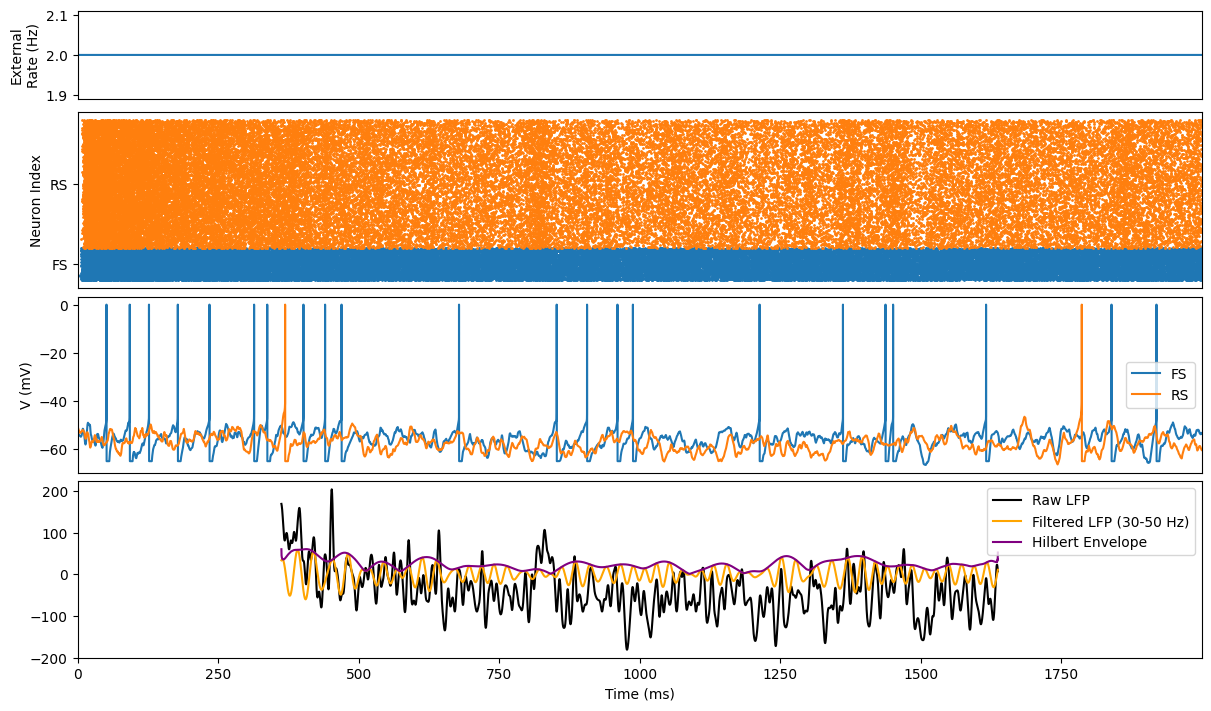

In [36]:
simulate_ai_net()